In [1]:
# 导入包
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
import time
from sklearn.model_selection import train_test_split
import fetool 
import tushare as ts
import talib as tl
from IPython.display import Image

#配置Tushare_pro
pro = ts.pro_api()

<font color='red' size=6>**基于LSTM的股票价格预测**<font>

In [2]:
Image(url= "./pictures/flowchart.png", width=800, height=1000)

#### **基于LSTM进行股票价格预测**

- 构建特征集合 包括通过传统的财务基本面指标、技术指标和宏观经济指标
- 预测的标签为下一天的收盘价
- 一下为全局参数

In [3]:
# 全局参数配置
class conf:
    start_time="20110107"      #数据开始的时间
    end_time="20210107"        #数据结束的时间
    ts_code='601818.SH'        #股票代码
    seq_len = 20               #LSTM输入的序列长度
    batch_size = 64            #每次参与训练的
    epochs=20                  #训练轮数
    loss='mean_squared_error'  #训练时的损失函数
    optimizer='Adam'           #训练模型的优化器
    learning_rate=0.01         #学习率
    select_percentile=20       #特征工程中所选择特征的比例
    val_split=0.2              #验证集切分比例
    test_split=0.2             #测试集切分比例

<font color='red' size=5> **STEP1 构造因子池** <font>

<font color='brown' size=4> **1 读取日线数据** <font>

In [4]:
#日线行情数据
start_time=conf.start_time
end_time=conf.end_time
ts_code=conf.ts_code

df_daily = pro.daily(ts_code=ts_code, start_date=start_time, end_date=end_time)
df_daily.to_csv('./data/股票日线行情.csv')

<font color='brown' size=4> **2 构造技术分析指标** <font> 


In [5]:
Image(url= "./pictures/TA-Lib.png", 
      width=800, height=100)

In [6]:
#技术指标
df_tech=df_daily.copy(deep=True)
df_tech=df_tech.iloc[::-1]

#布林通道类
for days in [5,10,30,90,180,270,365]:
    for threshold in [1.5,2,2.5]:
        df_tech[f'BBANDS_{days}days_{threshold}STD_upper'],df_tech[f'BBANDS_{days}days_{threshold}STD_middle'],df_tech[f'BBANDS_{days}days_{threshold}STD_lower']=tl.BBANDS(df_tech['close'],nbdevup=threshold, nbdevdn=threshold,timeperiod=days)
#MA类
for days in [5,10,30,90,180,270,365]:
    df_tech[f'DEMA_{days}days']=tl.DEMA(df_tech['close'],timeperiod=days)
    df_tech[f'EMA_{days}days']=tl.EMA(df_tech['close'],timeperiod=days)
    df_tech[f'SMA_{days}days']=tl.SMA(df_tech['close'],timeperiod=days)
    df_tech[f'KAMA_{days}days']=tl.KAMA(df_tech['close'],timeperiod=days)
    df_tech[f'WMA_{days}days']=tl.WMA(df_tech['close'],timeperiod=days)
    df_tech[f'TRIMA_{days}days']=tl.TRIMA(df_tech['close'],timeperiod=days)
    
#Momentum类
for days in [5,10,30,90,180,270,365]:   
    df_tech[f'ADX_{days}days']=tl.ADX(df_tech['high'],df_tech['low'],df_tech['close'],timeperiod=days)
    df_tech[f'ADXR_{days}days']=tl.ADX(df_tech['high'],df_tech['low'],df_tech['close'],timeperiod=days)
    df_tech[f'AROONOSC_{days}days']=tl.AROONOSC(df_tech['high'],df_tech['low'],timeperiod=days)
    df_tech[f'DX_{days}days']=tl.DX(df_tech['high'],df_tech['low'],df_tech['close'],timeperiod=days)
    df_tech[f'MFI_{days}days']=tl.MFI(df_tech['high'],df_tech['low'],df_tech['close'],df_tech['vol'],timeperiod=days)
    df_tech[f'MOM_{days}days']=tl.MOM(df_tech['close'],timeperiod=days)
    df_tech[f'RSI_{days}days']=tl.RSI(df_tech['close'],timeperiod=days)
    df_tech[f'WILLR_{days}days']=tl.WILLR (df_tech['high'],df_tech['low'],df_tech['close'],timeperiod=days)

df_tech[f'MACD_macd'],df_tech[f'MACD_macdsignal'],df_tech[f'MACD_macdhist']=tl.MACD(df_tech['close'])
df_tech[f'MAMA_mama'],df_tech[f'MAMA_fama']=tl.MAMA(df_tech['close'])
df_tech[f'HT_TRENDLINE']=tl.HT_TRENDLINE(df_tech['close'])
df_tech[f'SAR']=tl.SAR (df_tech['high'],df_tech['low'])
df_tech[f'SAREXT']=tl.SAR (df_tech['high'],df_tech['low'])
df_tech[f'ULTOSC']=tl.ULTOSC(df_tech['high'],df_tech['low'],df_tech['close'])
df_tech[f'BOP']=tl.BOP(df_tech['open'],df_tech['high'],df_tech['low'],df_tech['close'])
df_tech[f'APO']=tl.APO(df_tech['close'])
df_tech[f'PPO']=tl.PPO(df_tech['close'])

#Pattern Recognition类
for func in tl.get_function_groups()['Pattern Recognition']:
    if abs(eval('tl.'+func)(df_tech['open'],df_tech['high'],df_tech['low'],df_tech['close']).sum())>10000:#至少出现100次的形态 否则太过稀疏 不可取
        df_tech[func]=eval('tl.'+func)(df_tech['open'],df_tech['high'],df_tech['low'],df_tech['close'])
df_tech.to_csv('./data/技术分析.csv')
df_tech.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,...,SAREXT,ULTOSC,BOP,APO,PPO,CDLDOJI,CDLHIGHWAVE,CDLLONGLEGGEDDOJI,CDLRICKSHAWMAN,CDLSPINNINGTOP
2415,601818.SH,20110107,4.00,4.28,3.94,4.19,4.02,0.17,4.23,4077380.38,...,NaN,NaN,0.558824,NaN,NaN,0,0,0,0,0
2414,601818.SH,20110110,4.13,4.19,4.08,4.09,4.19,-0.10,-2.39,1790244.27,...,3.94000,NaN,-0.363636,NaN,NaN,0,0,0,0,0
2413,601818.SH,20110111,4.06,4.22,4.05,4.16,4.09,0.07,1.71,2022397.50,...,3.94500,NaN,0.588235,NaN,NaN,0,0,0,0,0
2412,601818.SH,20110112,4.16,4.22,4.08,4.18,4.16,0.02,0.48,2353180.13,...,3.95600,NaN,0.142857,NaN,NaN,0,0,0,0,0
2411,601818.SH,20110113,4.17,4.17,4.08,4.09,4.18,-0.09,-2.15,1733817.72,...,3.96656,NaN,-0.888889,NaN,NaN,0,0,0,0,0


<font color='brown' size=4> **3 构造基本面财务指标** <font> 

In [7]:
#财务基本面指标
df_incomestatement = pro.income(ts_code=ts_code, start_date=start_time, end_date=end_time)
df_balancesheet = pro.balancesheet(ts_code=ts_code, start_date=start_time, end_date=end_time)
df_cashflow = pro.cashflow(ts_code=ts_code, start_date=start_time, end_date=end_time)
df_financial_ratio = pro.fina_indicator(ts_code=ts_code, start_date=start_time, end_date=end_time)
df_incomestatement.to_csv('./data/incomestatement.csv')
df_balancesheet.to_csv('./data/balancesheet.csv')
df_cashflow.to_csv('./data/cashflow.csv')
df_financial_ratio.to_csv('./data/financial_ratio.csv')

df_financial_ratio.head()

,ts_code,ann_date,end_date,eps,dt_eps,total_revenue_ps,revenue_ps,capital_rese_ps,surplus_rese_ps,undist_profit_ps,...,ocf_yoy,roe_yoy,bps_yoy,assets_yoy,eqt_yoy,tr_yoy,or_yoy,q_sales_yoy,q_op_qoq,equity_yoy
0,601818.SH,20201031,20200930,0.52,0.47,2.0351,2.0351,1.0199,0.5000,2.5975,...,1318.5478,-18.5804,4.43,11.7075,14.0843,6.5854,6.5854,1.8338,48.2874,15.8031
1,601818.SH,20200829,20200630,0.31,0.28,1.3739,1.3739,1.0199,0.5000,2.3909,...,1136.7592,-23.3540,1.64,13.8378,1.3845,9.0340,9.0340,7.7811,-31.6428,17.1893
2,601818.SH,20200429,20200331,0.19,0.17,0.7107,0.7107,1.0199,0.5000,2.4816,...,803.3637,-6.9898,3.77,10.5332,3.1477,10.2296,10.2296,10.2296,63.9000,19.6441
3,601818.SH,20200328,20191231,0.68,0.62,2.5303,2.5303,1.0199,0.5000,2.2956,...,233.6066,-7.3255,9.91,8.6314,19.7500,20.4710,20.4710,12.8146,-37.8254,19.7500
4,601818.SH,20191031,20190930,0.57,0.51,1.9094,1.9094,1.0199,0.4643,2.3204,...,-111.6723,-6.2871,7.93,8.3977,17.9727,23.1897,23.1897,17.0238,1.5068,20.6972


In [8]:
#利率数据
df_shibor = pro.shibor(start_date=start_time, end_date=end_time)
df_shibor.columns=['ann_date', 'shibor_on', 'shibor_1w', 'shibor_2w', 'shibor_1m', 'shibor_3m', 'shibor_6m', 'shibor_9m', 'shibor_1y']
df_shibor.to_csv('./data/shibor.csv')

df_shibor.head()

,ann_date,shibor_on,shibor_1w,shibor_2w,shibor_1m,shibor_3m,shibor_6m,shibor_9m,shibor_1y
0,20210107,0.921,1.855,1.742,2.491,2.677,2.769,2.863,2.936
1,20210106,0.616,1.966,1.788,2.529,2.707,2.792,2.889,2.962
2,20210105,0.729,1.822,1.856,2.577,2.734,2.816,2.913,2.985
3,20210104,0.899,1.993,2.021,2.642,2.746,2.829,2.926,2.993
4,20201231,1.093,2.381,3.025,2.702,2.756,2.838,2.939,3.000


<font color='brown' size=4> **5 合并所有因子 并进行预处理** <font> 

In [9]:
#合并表
from functools import reduce 
df_others=[df_incomestatement,df_balancesheet,df_cashflow,df_financial_ratio,df_shibor]
for df_reindex in df_others:
    df_reindex=df_reindex.iloc[::-1]
    
df=[df_tech,df_incomestatement,df_balancesheet,df_cashflow,df_financial_ratio,df_shibor]
df_merge= reduce(lambda left,right: pd.merge(left,right,left_on='trade_date',right_on='ann_date',how="left"), df)

df_merge.drop_duplicates(subset='trade_date',inplace=True)

#消去带有时间的列
df_cleaned=df_merge.copy(deep=True)
df_cleaned.index=df_merge['trade_date'].values

remove_columns=list(df_merge.columns[df_merge.columns.str.contains("date")])
remove_columns=remove_columns+['ts_code_x','ts_code_y','ts_code']
df_cleaned.drop(columns=remove_columns,inplace=True)
df_cleaned.insert(0,'return',np.log(df_cleaned.close.shift(-1)/df_cleaned.close))

#删除全空的数据
drop_null=[]

for column in df_cleaned.columns:
    null_num=df_cleaned[column].isnull().sum()
    if null_num==df_cleaned.shape[0]:
        drop_null.append(column)
        
df_drop_null=df_cleaned.drop(columns=drop_null)

#先前值填充 主要填财务数据 
df_filled=df_drop_null.fillna(method='ffill')
#前值填充完毕之后 后值填充 主要填充技术分析数据
df_filled=df_filled.fillna(method='bfill')
df_filled.to_csv('./data/数据集.csv')
df_filled.head()

,return,open,high,low,close,pre_close,change,pct_chg,vol,amount,...,q_op_qoq,equity_yoy,shibor_on,shibor_1w,shibor_2w,shibor_1m,shibor_3m,shibor_6m,shibor_9m,shibor_1y
20110107,-0.024156,4.00,4.28,3.94,4.19,4.02,0.17,4.23,4077380.38,1691367.374,...,-7.8478,56.7407,2.28,2.999,3.794,4.1302,3.8664,4.1,4.2584,4.4002
20110110,0.016970,4.13,4.19,4.08,4.09,4.19,-0.10,-2.39,1790244.27,738968.893,...,-7.8478,56.7407,2.28,2.999,3.794,4.1302,3.8664,4.1,4.2584,4.4002
20110111,0.004796,4.06,4.22,4.05,4.16,4.09,0.07,1.71,2022397.50,837106.203,...,-7.8478,56.7407,2.28,2.999,3.794,4.1302,3.8664,4.1,4.2584,4.4002
20110112,-0.021766,4.16,4.22,4.08,4.18,4.16,0.02,0.48,2353180.13,973950.970,...,-7.8478,56.7407,2.28,2.999,3.794,4.1302,3.8664,4.1,4.2584,4.4002
20110113,-0.024754,4.17,4.17,4.08,4.09,4.18,-0.09,-2.15,1733817.72,712609.280,...,-7.8478,56.7407,2.28,2.999,3.794,4.1302,3.8664,4.1,4.2584,4.4002


<font color='red' size=5> **STEP2 特征工程** <font>

#### **特征工程**

- 由于对于预测股票价格而言 几百个因子或许过量 可能会导致过拟合 故需要进行特征工程完成特征的筛选
- 筛选的方法为RFE递归式特征消除法
- 基模型选为默认参数的LightGBM模型

### <font color='red' size=3>TIPS: Recursive Feature Elimination (SBS) 递归式特征消除 <font/>
- **Deterministic Algorithms 确定性算法**
在不考虑**模型随机性**的情况下，给定**相同**的数据输入，确定性算法将始终输出**相同**的**最优特征子集**。顺序向前选择（SFS），顺序向后选择（SBS）均为确定性算法。

- **顺序向前选择（SFS）**方法将从最优**单变量模型**开始，然后在迭代中，其会在**上一步变量子集的基础**上，以穷举的方法在现有变量子集中**增加一个新变量**，使得新增一个变量后的变量子集可以获得最大的模型表现提升。迭代将持续直到**所选变量的数量满足要求**为止。

- **顺序向后选择（SBS）**则从适合一个**包含所有变量**的模型开始，然后在迭代中，其会在上一步变量子集的基础上，以穷举的方法在现有变量子集中**删除**一个对模型**负影响最低**的变量，直到所选特征的**数量满足要求**为止。  
- 但是顺序向前选择（SFS）方法和顺序向后选择（SBS）均为逐步**（step-wise）**的方法，都可能会陷**入局部最优状态**。
- 在这里实现**递归特征消除（SBS）**方法。

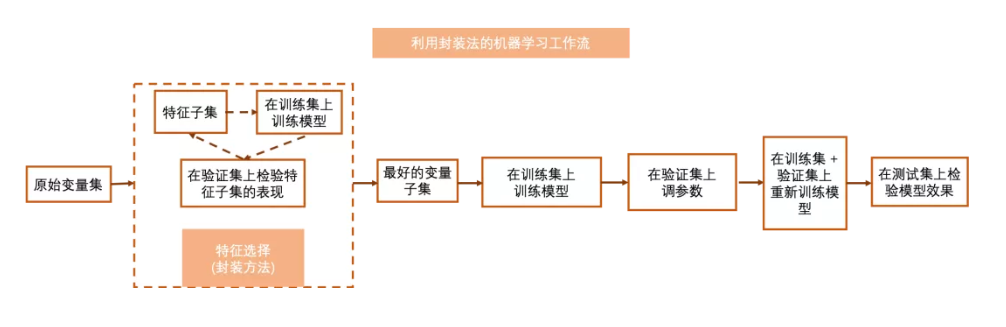

In [10]:
Image(filename='D:\\朱雀投资\\7.20 特征工程\\封装法.png', 
      width=1000, height=500)

In [11]:
Image(url= "./pictures/LightGBM.png", 
      width=500, height=100)

In [12]:
# 数据导入以及初步处理
data=pd.read_csv('./data/数据集.csv',index_col=0)

#切分数据集
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(data,data['close'],test_size=conf.test_split,shuffle=False)

#特征工程 采用基于Lgb的RFE
wrapper_selector=fetool.Feature_Selector_with_values(X_train_raw,X_train_raw['close'].shift(-1).fillna(method='ffill'))
data_select=wrapper_selector.Wrapper_LGBMRegressor(percentile=conf.select_percentile)

#归一化数据
scaler=MinMaxScaler()
X_train_scalered=scaler.fit_transform(data_select)
X_test_scalered=scaler.transform(X_test_raw[data_select.columns])

---正在使用Wrapper_LGBMRegressor接口--- 
   时耗约10s(step=100)  


<font color='red' size=5> **STEP3 数据格式转换** <font>

#### **数据格式转换**

- 由于LSTM模型的输入格式为（samples,seq_len,feature_nums）即（样本数，序列长度，特征数） 故需要对原始数据进行转换

In [13]:
def craeat_lstm_data(X_train, X_test, y_train, y_test,seq_len):
    train_input = []
    train_output = []
    test_input = []
    test_output = []
    for i in range(seq_len-1, len(X_train)-1):
        train_input.append(X_train.iloc[i+1-seq_len:i+1])
        train_output.append(y_train.iloc[i+1])

    for j in range(seq_len-1, len(X_test)-1):    
        test_input.append(X_test.iloc[j+1-seq_len:j+1])
        test_output.append(y_test.iloc[j+1])

    # LSTM接受数组类型的输入
    train_x = np.array(train_input)
    train_y = np.array(train_output)
    test_x = np.array(test_input) 
    test_y = np.array(test_output)
    
    return train_x,train_y,test_x,test_y

In [14]:
train_x,train_y,test_x,test_y=craeat_lstm_data(pd.DataFrame(X_train_scalered), pd.DataFrame(X_test_scalered), y_train_raw, y_test_raw,conf.seq_len)
print(train_x.shape,train_y.shape)

(1912, 20, 79) (1912,)


<font color='red' size=5> **STEP4 模型搭建** <font>

#### **模型搭建**

- 基于Keras进行LSTM模型的建立

In [15]:
Image(url= "./pictures/keras.png", 
      width=500, height=100)

In [16]:
Image(url= "https://pic4.zhimg.com/80/v2-47137ca8f0ffc3a3778c5223881b75f7_1440w.jpg", 
      width=500, height=100)

In [17]:
Image(url= "https://pic4.zhimg.com/80/v2-561a4eeb23e5bdd3a0bb08d818511aa3_1440w.jpg", 
      width=500, height=100)

In [18]:
Image(url= "LSTMcell.png", 
      width=500, height=100)

In [19]:
#模型结构 可以修改

model = Sequential()


model.add(LSTM(input_shape=(conf.seq_len,train_x.shape[-1]), units=50, return_sequences=True))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(100))
model.add(Dense(units=1))

start = time.time() #计时器

model.compile(loss=conf.loss, optimizer=optimizers.Adam(learning_rate=conf.learning_rate))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 50)            26000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 96,601
Trainable params: 96,601
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = history = model.fit(train_x, train_y, batch_size=conf.batch_size, epochs=conf.epochs, 
                              validation_split=conf.val_split)
print('compilatiom time:', time.time()-start)

Epoch 1/20
24/24 [==============================] - 6s 105ms/step - loss: 9.6271 - val_loss: 0.1658
Epoch 2/20
24/24 [==============================] - 0s 20ms/step - loss: 0.6626 - val_loss: 0.2919
Epoch 3/20
24/24 [==============================] - 0s 20ms/step - loss: 0.2165 - val_loss: 0.0109
Epoch 4/20
24/24 [==============================] - 0s 19ms/step - loss: 0.0686 - val_loss: 0.0055
Epoch 5/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0619 - val_loss: 0.0120
Epoch 6/20
24/24 [==============================] - 0s 19ms/step - loss: 0.0555 - val_loss: 0.0046
Epoch 7/20
24/24 [==============================] - 1s 21ms/step - loss: 0.0463 - val_loss: 0.0092
Epoch 8/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0413 - val_loss: 0.0056
Epoch 9/20
24/24 [==============================] - 1s 23ms/step - loss: 0.0422 - val_loss: 0.0085
Epoch 10/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0344 - val_loss: 0.0287
Epoch 11

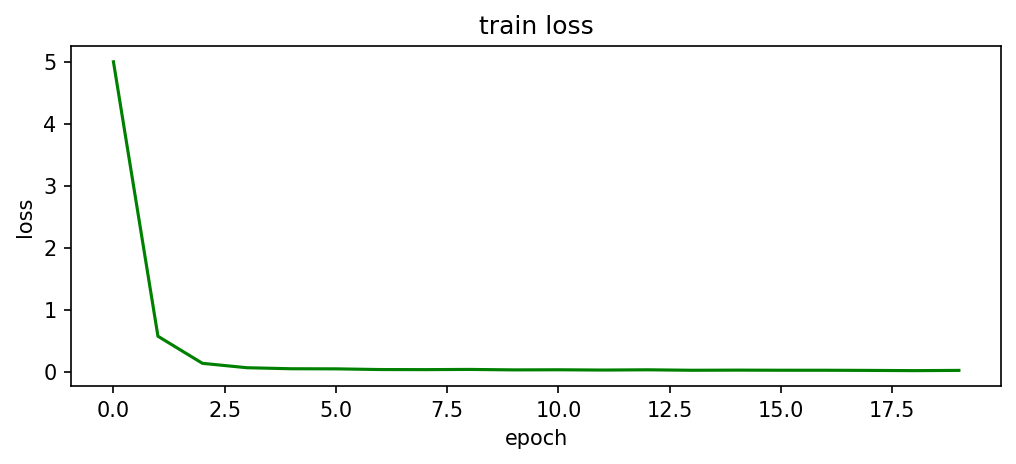

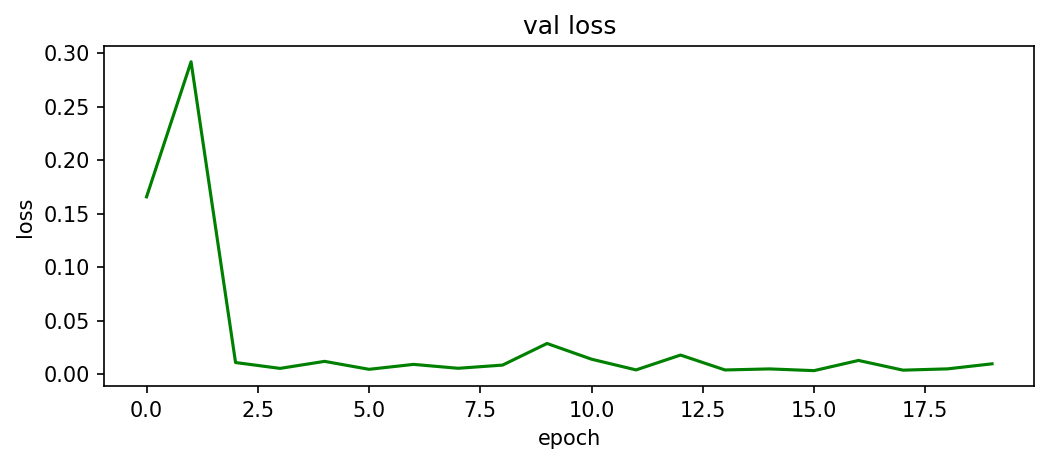

In [26]:
plt.figure(figsize=(8, 3),dpi=150)


plt.plot(history.history['loss'],linewidth=1.5,color='g')
plt.title('train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(8, 3),dpi=150)

plt.plot(history.history['val_loss'],linewidth=1.5,color='g')
plt.title('val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [22]:
#训练集 测试集上误差
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

trainScore = math.sqrt(mean_squared_error(train_y, trainPredict[:, 0]))
print('Train Sccore %.2f RMSE' %(trainScore))
testScore = math.sqrt(mean_squared_error(test_y, testPredict[:, 0]))
print('Test Sccore %.2f RMSE' %(testScore))

Train Sccore 0.09 RMSE
Test Sccore 0.07 RMSE


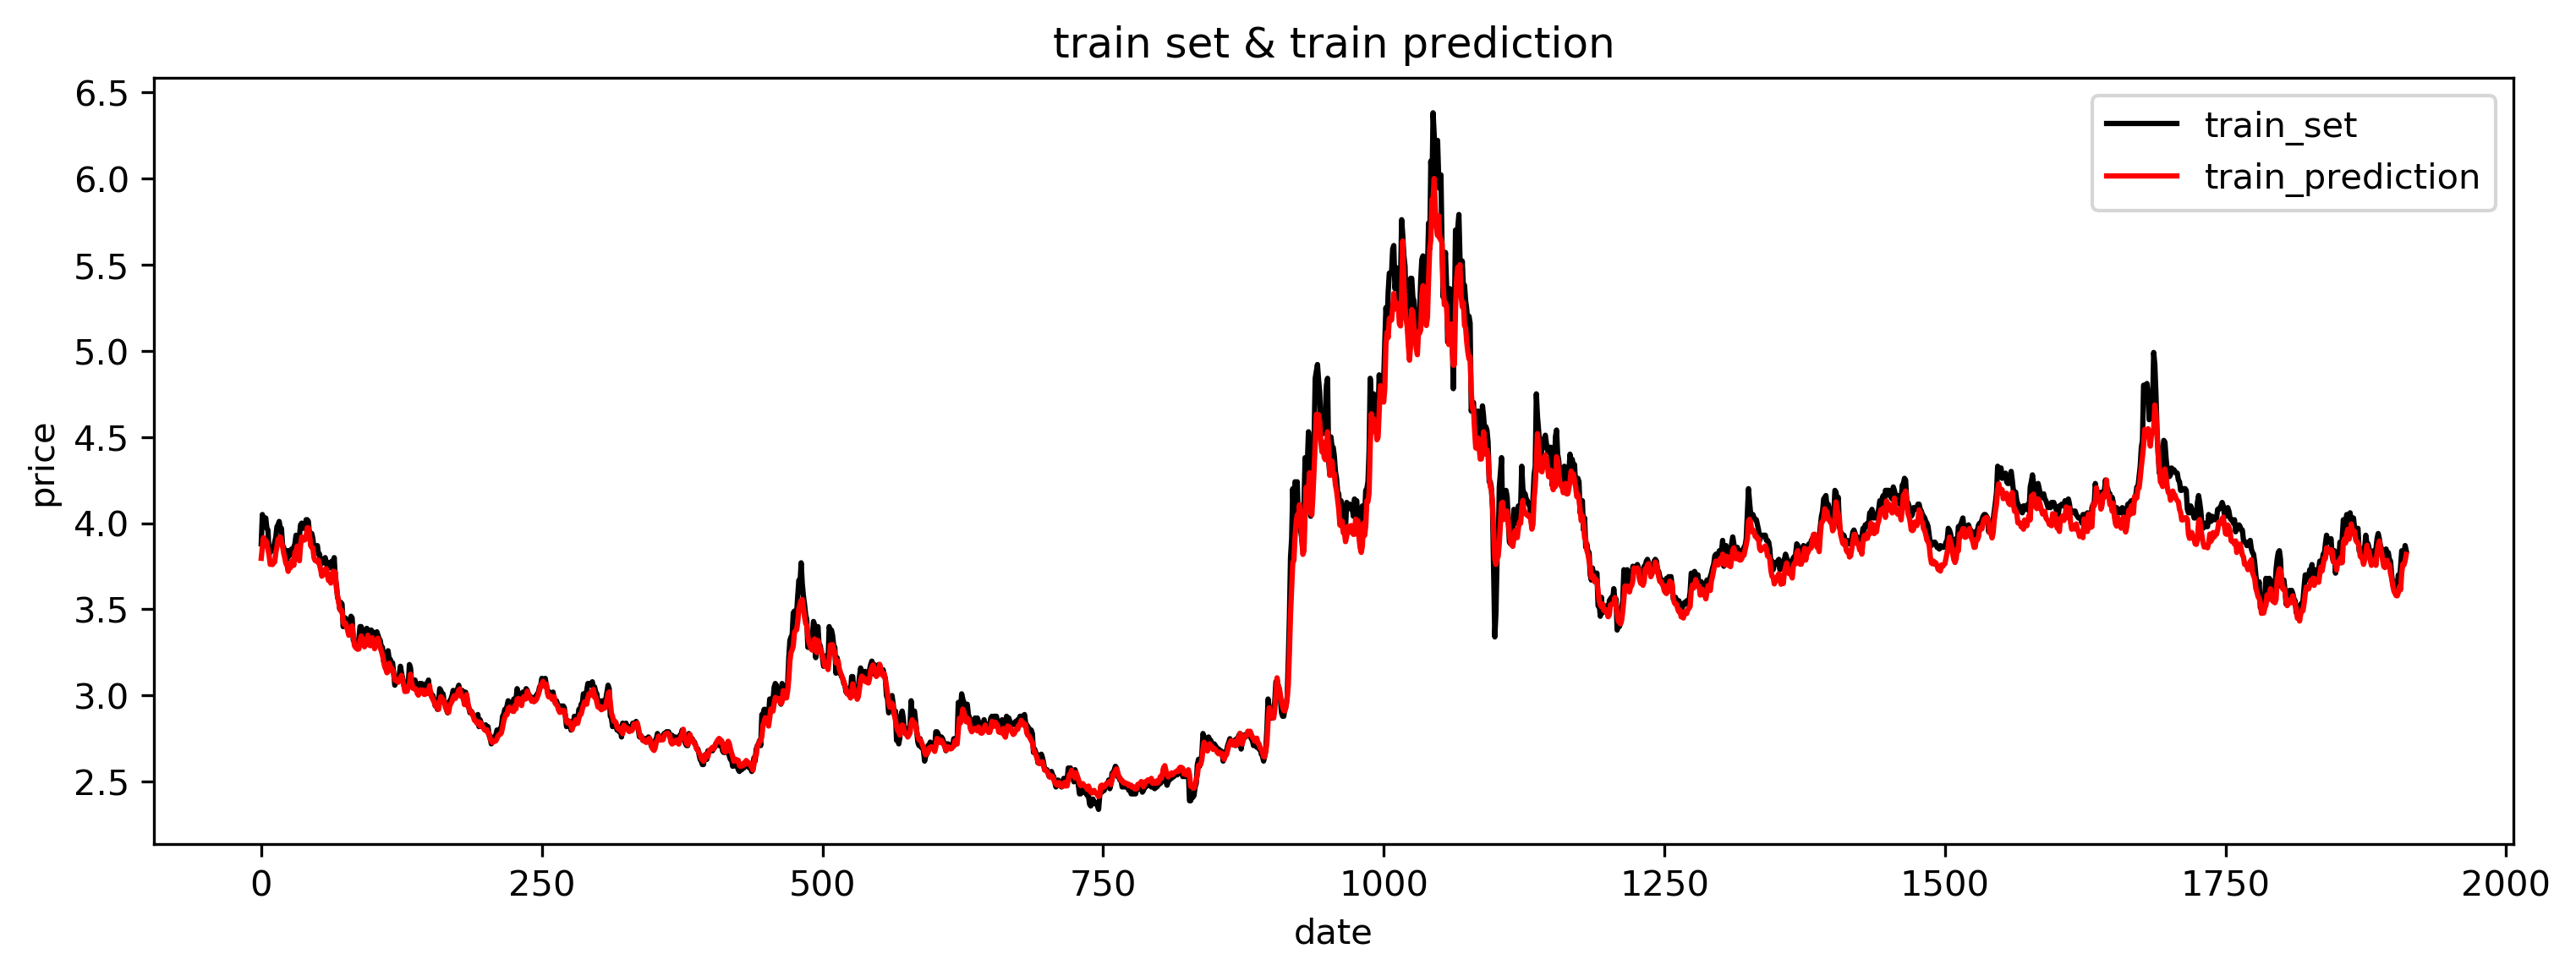

In [23]:
fig1 = plt.figure(figsize=(12, 4),dpi=300)
plt.plot(train_y,color='black',label='train_set')
plt.plot(trainPredict,color='r',label='train_prediction')
plt.title('train set & train prediction')
plt.ylabel('price')
plt.xlabel('date')
plt.legend()
plt.show()

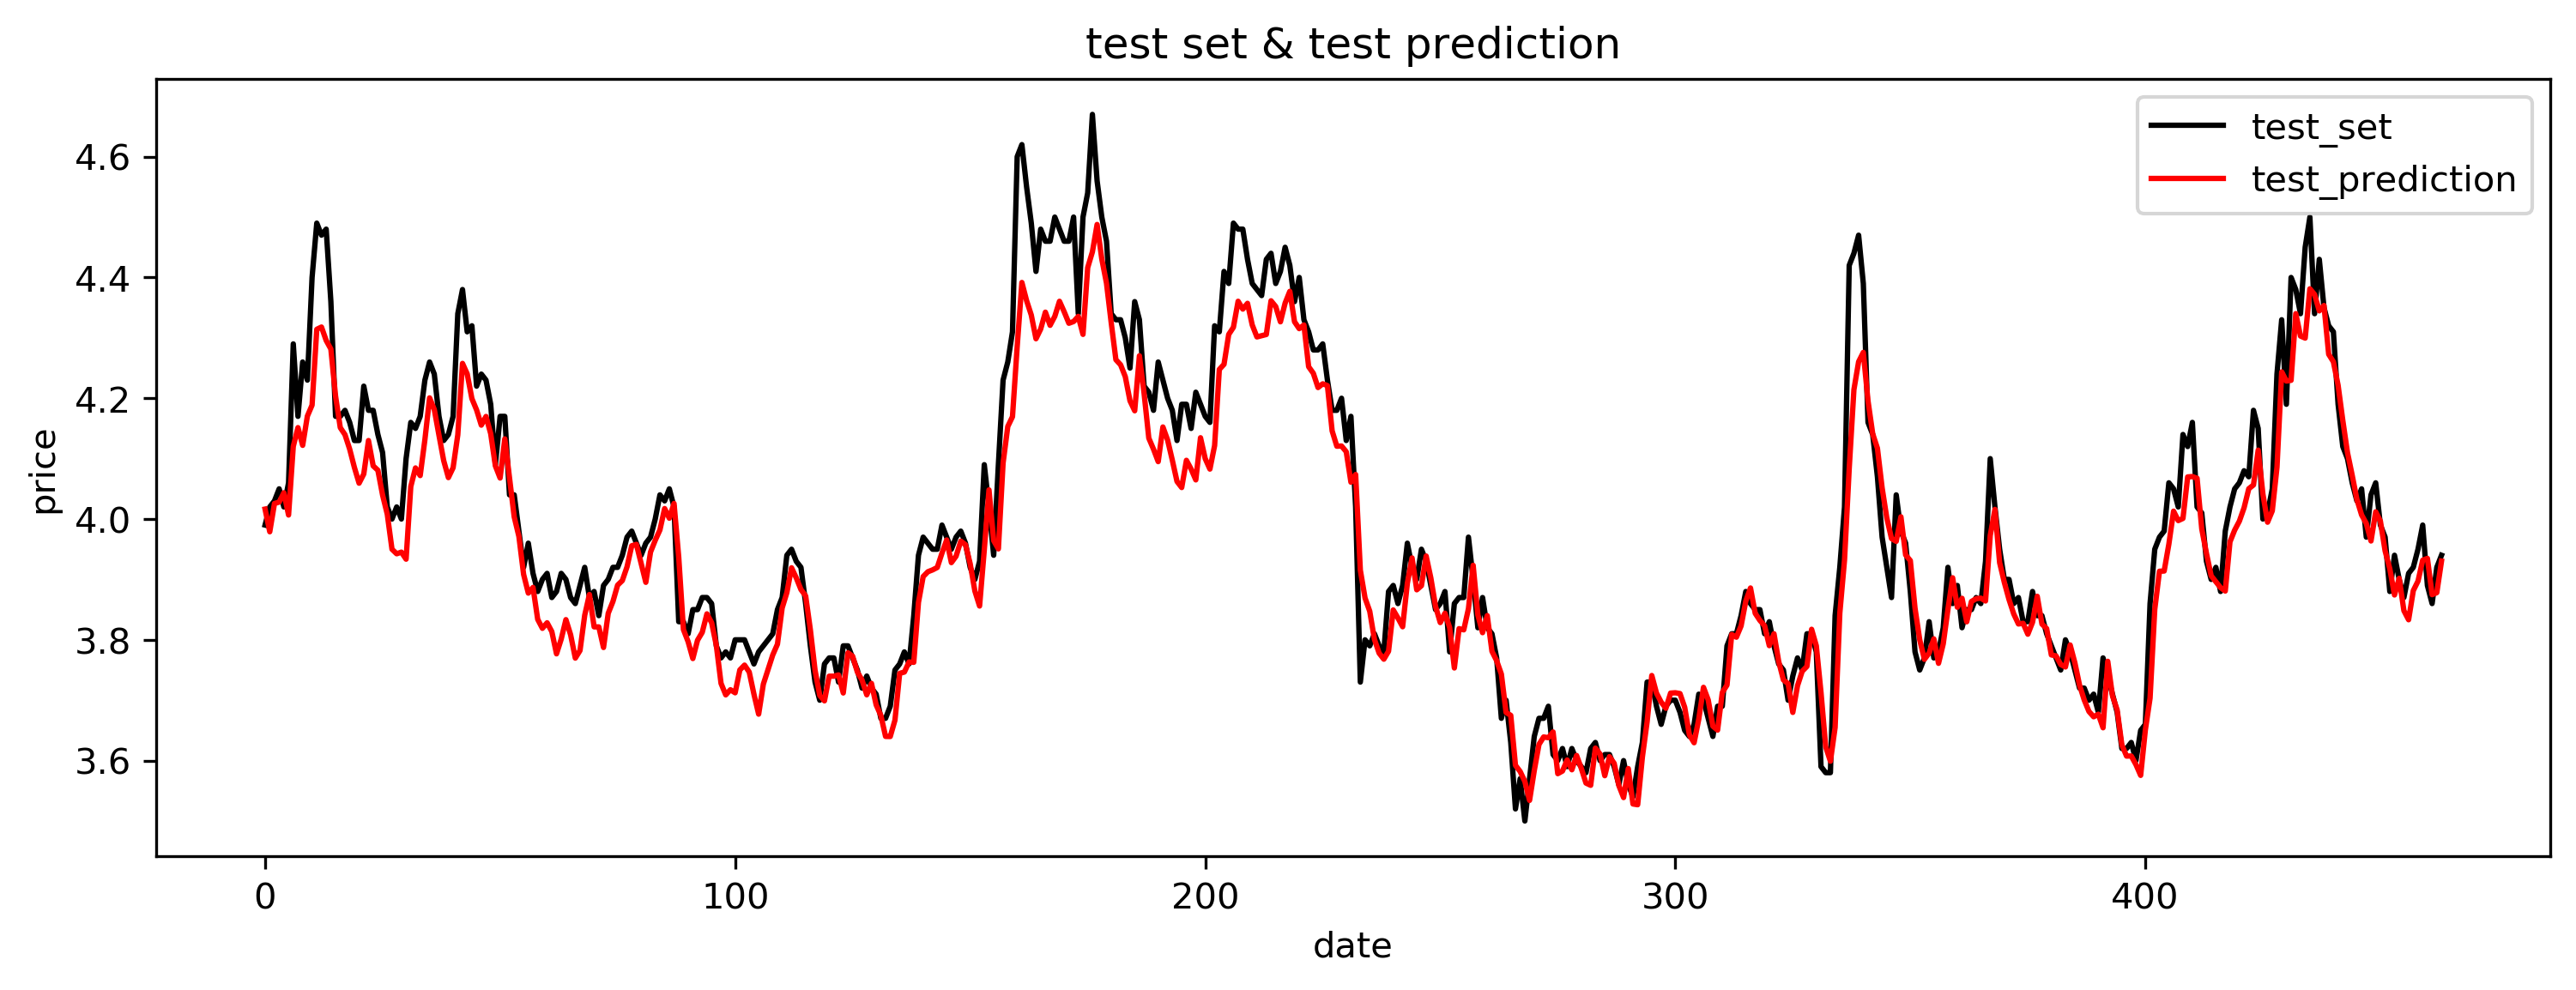

In [24]:
fig2 = plt.figure(figsize=(12, 4),dpi=300)
plt.plot(test_y,color='black',label='test_set')
plt.plot(testPredict,color='r',label='test_prediction')
plt.title('test set & test prediction')
plt.ylabel('price')
plt.xlabel('date')
plt.legend()
plt.show()

<font color='red' size=5> **STEP5 预测** <font>

In [25]:
tomorrow_predict=model.predict((X_test_scalered[-conf.seq_len:]).reshape(1,conf.seq_len,data_select.shape[1]))[0][0]

print(f"明天 {conf.ts_code} 的收盘价预测值为： {tomorrow_predict:.3f}")

明天 601818.SH 的收盘价预测值为： 3.941
